# [E-4] 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다. 

In [1]:
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
! mv ratings_*.txt ~/aiffel/sentiment_classification

--2021-01-21 16:29:34--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
접속 raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  10.4MB/s    in 1.3s    

2021-01-21 16:29:36 (10.4 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2021-01-21 16:29:36--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
접속 raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  6.80MB/s    in 0.7s    

2021-

python3 -m pip install konlpy
sudo apt-get install curl git
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 필요한 데이터 셋을 준비하고  konlpy를 다운받아 두었습니다.

## 1) 데이터 준비와 확인

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
##### 데이터를 살펴보니 영화에 대한 리뷰라는것을 잘 확인 할수가 있네요.

## 2) 데이터로더 구성   

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.   


    데이터의 중복 제거   
    NaN 결측치 제거   
    한국어 토크나이저로 토큰화   
    불용어(Stopwords) 제거   
    사전word_to_index 구성   
    텍스트 스트링을 사전 인덱스 스트링으로 변환   
    X_train, y_train, X_test, y_test, word_to_index 리턴   
    

In [5]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 가공되지 않은 날것의 텍스트 파일을 가공해서 쓰라니 이거 실화 입니까? 여기부터 멘붕이 왔다. 1시간 2시간 시간은 계속흐르고 이게 뭐다냐!!! 그러나 늦은 밤까지 학구열을 불태우는 우리를 발견하신 맘착한 영표퍼실님과 영석펴실님과 바롬 퍼실님 덕분에 맘편하게 복붇을 하게 되어 첫 관문을 겨우겨우 해결 했습니다. 데이터가 친절해야지 콜록콜록...

## 3) 모델구성을 위한 데이터 분석 및 가공   


    데이터셋 내 문장 길이 분포   
    적절한 최대 문장 길이 지정   
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가   
    

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


#### 문장 최대 길이의 값도 전체 모델 성능에 영향을 미친다니 적절한 값을 찾기 위해 전체 데이터셋 분포를 확인해보니 최대 문장길이가 116이네요. 그리고 padding 방식은 'post'로 하였습니다.

## 4) 모델구성 및 validation set 구성   

모델은 3가지 이상 다양하게 구성하여 실험해 보세요. 


In [11]:
# Conv1D 모델사용

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
#LSTM 모델사용

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [13]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 모델

vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


#### Conv1D 모델, LSTM 모델, GlobalMaxPooling1D() 레이어 하나만 사용하는 모델 세가지를 사용할 계획입니다.

In [14]:
# validation set 12000건 분리
x_val = X_train[:12000]   
y_val = y_train[:12000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


#### 훈련용 데이터셋 25000건중 12000건을 분리하여 검증셋(validation set)으로 사용하도록 구성했습니다.

## 5) 모델 훈련 개시

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 40   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          4496      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 9s 32ms/step - loss: 0.4580 - accuracy: 0.7828 - val_loss: 0.3390 - val_accuracy: 0.8550
Epoch 2/7
266/266 [==============================] - 2s 7ms/step - loss: 0.3203 - accuracy: 0.8634 - val_loss: 0.3231 - val_accuracy: 0.8612
Epoch 3/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2864 - accuracy: 0.8815 - val_loss: 0.3134 - val_accuracy: 0.8691
Epoch 4/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2501 - accuracy: 0.8996 - val_loss: 0.3140 - val_accuracy: 0.8676
Epoch 5/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2066 - accuracy: 0.9223 - val_loss: 0.3272 - val_accuracy: 0.8709
Epoch 6/7
266/266 [==============================] - 2s 7ms/step - loss: 0.1597 - accuracy: 0.9426 - val_loss: 0.3557 - val_accuracy: 0.8662
Epoch 7/7
266/266 [==============================] - 2s 7ms/step - loss: 0.1192 - accuracy: 0.9594 - val_loss: 0.3965 - val_accuracy: 0.8627


In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4725 - accuracy: 0.8396
[0.4725327491760254, 0.8395955562591553]


#### Conv1D모델의  accuracy는  0.8396가 나왔네요.

In [18]:
#LSTM 모델사용

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 7s 26ms/step - loss: 0.5322 - accuracy: 0.7104 - val_loss: 0.3558 - val_accuracy: 0.8488
Epoch 2/7
266/266 [==============================] - 7s 26ms/step - loss: 0.3391 - accuracy: 0.8560 - val_loss: 0.3283 - val_accuracy: 0.8583
Epoch 3/7
266/266 [==============================] - 7s 25ms/step - loss: 0.3030 - accuracy: 0.8726 - val_loss: 0.3182 - val_accuracy: 0.8683
Epoch 4/7
266/266 [==============================] - 7s 25ms/step - loss: 0.2755 - accuracy: 0.8834 - val_loss: 0.3251 - val_accuracy: 0.8665
Epoch 5/7
266/266 [==============================] - 7s 26ms/step - loss: 0.2499 - accuracy: 0.8947 - val_loss: 0.3249 - val_accuracy: 0.8700
Epoch 6/7
266/266 [==============================] - 7s 27ms/step - loss: 0.2281 - accuracy: 0.9032 - val_loss: 0.3292 - val_accuracy: 0.8717
Epoch 7/7
266/266 [==============================] - 7s 25ms/step - loss: 0.2072 - accuracy: 0.9132 - val_loss: 0.3559 - val_accuracy: 0.8704


In [20]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4034 - accuracy: 0.8517
[0.40344545245170593, 0.8516793251037598]


#### LSTM 모델의  accuracy은  0.8516이 나왔네요.

In [21]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 모델

vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 6s 24ms/step - loss: 0.5227 - accuracy: 0.7577 - val_loss: 0.3436 - val_accuracy: 0.8522
Epoch 2/7
266/266 [==============================] - 6s 23ms/step - loss: 0.3194 - accuracy: 0.8657 - val_loss: 0.3150 - val_accuracy: 0.8626
Epoch 3/7
266/266 [==============================] - 6s 23ms/step - loss: 0.2711 - accuracy: 0.8903 - val_loss: 0.3110 - val_accuracy: 0.8677
Epoch 4/7
266/266 [==============================] - 7s 26ms/step - loss: 0.2307 - accuracy: 0.9100 - val_loss: 0.3139 - val_accuracy: 0.8679
Epoch 5/7
266/266 [==============================] - 7s 26ms/step - loss: 0.1907 - accuracy: 0.9294 - val_loss: 0.3279 - val_accuracy: 0.8720
Epoch 6/7
266/266 [==============================] - 7s 25ms/step - loss: 0.1506 - accuracy: 0.9486 - val_loss: 0.3427 - val_accuracy: 0.8730
Epoch 7/7
266/266 [==============================] - 6s 24ms/step - loss: 0.1127 - accuracy: 0.9650 - val_loss: 0.3647 - val_accuracy: 0.8712


In [23]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4378 - accuracy: 0.8455
[0.43782246112823486, 0.8454543352127075]


#### GlobalMaxPooling1D 모델의  accuracy도  0.8455이 나왔네요. 어느 모델을 써도 큰차이가 없을듯 하지만  LSTM모델이 조금 높습니다.

## 6) Loss, Accuracy 그래프 시각화

In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4378 - accuracy: 0.8455
[0.43782246112823486, 0.8454543352127075]


In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


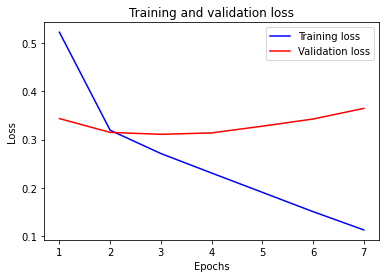

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### loss, metric을 체크하면 지금 모델이 underfit 되고 있는지, overfit 되고 있는지, 또는 그 외의 문제가 있는지를 알 수 있습니다. 이런 문제점을 체크함으로써 모델의 성능을 높이기 위해 데이터를 추가해야 하는지, feature를 늘려야 하는지, 모델의 크기를 늘려야 하는지 다른 문제를 봐야하는지를 알 수 있죠. 간단하게 말하자면 Train set과 Validation set의 loss가 같이 충분히 떨어지는게 좋습니다. 위 그래프는 validation set loss 에포크2를 기점으로 상승하는 것을 볼수 있습니다. 그럼 이 시점부터 오버피팅 된다는 건데 이게 잘 이해가 안가긴 합니다. 그럼 에포크를 2만 줘도 될까요? 이렇게  짧은 학습만으로 좋은 학습이 될수 있는지 이 AI맹은 이해가 어렵습니다. 나중에 퍼실님들께 물어봐야겠네요.

## 7) 학습된 Embedding 레이어 분석

In [27]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [28]:
import os  

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.12228241, -0.07429194, -0.10975125, -0.11223913, -0.05160241,
       -0.10585713, -0.09726408,  0.35894704, -0.1061317 , -0.10762132,
       -0.1025951 , -0.02402776, -0.00867452, -0.0129066 , -0.13015912,
       -0.06372445, -0.03926619, -0.12453793, -0.12995067, -0.05241904,
       -0.07883701, -0.07072418, -0.11107545, -0.15016775, -0.12751435,
        0.10361876, -0.02260922, -0.10209123, -0.10428516, -0.11316857,
       -0.08022484, -0.0953861 , -0.15359257, -0.09251904, -0.09876927,
       -0.08604755, -0.10492505, -0.12090148, -0.00268767, -0.10618176,
       -0.1023434 , -0.09816681, -0.12430054,  0.04685304, -0.13773035,
       -0.03033251, -0.00047974, -0.09005254, -0.10240762, -0.06108148,
       -0.08139846, -0.11329286, -0.05714973, -0.10019092, -0.11782655,
       -0.09992022, -0.06288098, -0.13375235, -0.08894271, -0.08829362,
       -0.09009536, -0.12287966, -0.07833181, -0.14076932, -0.1225758 ,
       -0.03276773, -0.12622783, -0.02175479, -0.07229403, -0.06

In [30]:
word_vectors.similar_by_word("눈물")

[('원피스', 0.383182168006897),
 ('서구', 0.36453112959861755),
 ('놀란', 0.3596607446670532),
 ('봤', 0.3453797698020935),
 ('놀라운', 0.34436145424842834),
 ('시절', 0.34349551796913147),
 ('된', 0.3374200761318207),
 ('마스터', 0.3358646035194397),
 ('던', 0.33457693457603455),
 ('일대기', 0.33455270528793335)]

##### 임베딩 레이어를 분석하고 눈물이라는 단어를와 유사한 단어를 유도해보니 그렇게  유의미한 학습이 된것 같지는 않네요.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [37]:
import os
from gensim import models
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
ko_model = models.Word2Vec.load(word2vec_path)

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj05/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj05/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [39]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### 그나마 정확도가 조금 높았던 LSTM모델을 사용하겠습니다.

In [44]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 7s 26ms/step - loss: 0.0866 - accuracy: 0.9701 - val_loss: 0.5328 - val_accuracy: 0.8635
Epoch 2/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0800 - accuracy: 0.9732 - val_loss: 0.5244 - val_accuracy: 0.8630
Epoch 3/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0790 - accuracy: 0.9737 - val_loss: 0.5287 - val_accuracy: 0.8619
Epoch 4/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0762 - accuracy: 0.9748 - val_loss: 0.5469 - val_accuracy: 0.8614
Epoch 5/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0753 - accuracy: 0.9750 - val_loss: 0.5443 - val_accuracy: 0.8577
Epoch 6/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0739 - accuracy: 0.9754 - val_loss: 0.5758 - val_accuracy: 0.8612
Epoch 7/10
266/266 [==============================] - 7s 25ms/step - loss: 0.0725 - accuracy: 0.9764 - val_loss: 0.5653 - val_accuracy: 0.8578

In [45]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7082 - accuracy: 0.8354
[0.7082197070121765, 0.8354049324989319]


#### accuracy가 0.8354가 나왔네요.

In [46]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
266/266 [==============================] - 7s 26ms/step - loss: 0.0674 - accuracy: 0.9781 - val_loss: 0.5479 - val_accuracy: 0.8603
Epoch 2/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0620 - accuracy: 0.9804 - val_loss: 0.5698 - val_accuracy: 0.8570
Epoch 3/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0601 - accuracy: 0.9813 - val_loss: 0.5952 - val_accuracy: 0.8560
Epoch 4/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0593 - accuracy: 0.9813 - val_loss: 0.5834 - val_accuracy: 0.8564
Epoch 5/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0582 - accuracy: 0.9816 - val_loss: 0.5912 - val_accuracy: 0.8571
Epoch 6/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0564 - accuracy: 0.9824 - val_loss: 0.6232 - val_accuracy: 0.8570
Epoch 7/15
266/266 [==============================] - 7s 25ms/step - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.6188 - val_accuracy: 0.8563

In [47]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7825 - accuracy: 0.8291
[0.7825247645378113, 0.8291189670562744]


In [48]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 7s 26ms/step - loss: 0.0482 - accuracy: 0.9850 - val_loss: 0.6214 - val_accuracy: 0.8567
Epoch 2/7
266/266 [==============================] - 7s 26ms/step - loss: 0.0452 - accuracy: 0.9860 - val_loss: 0.6769 - val_accuracy: 0.8553
Epoch 3/7
266/266 [==============================] - 7s 26ms/step - loss: 0.0468 - accuracy: 0.9854 - val_loss: 0.6413 - val_accuracy: 0.8552
Epoch 4/7
266/266 [==============================] - 7s 25ms/step - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.6359 - val_accuracy: 0.8572
Epoch 5/7
266/266 [==============================] - 7s 25ms/step - loss: 0.0445 - accuracy: 0.9863 - val_loss: 0.6435 - val_accuracy: 0.8557
Epoch 6/7
266/266 [==============================] - 7s 25ms/step - loss: 0.0439 - accuracy: 0.9863 - val_loss: 0.6740 - val_accuracy: 0.8543
Epoch 7/7
266/266 [==============================] - 7s 25ms/step - loss: 0.0430 - accuracy: 0.9868 - val_loss: 0.6613 - val_accuracy: 0.8520


In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7866 - accuracy: 0.8231
[0.7865651845932007, 0.8230770826339722]


#### accuracy를 높이고 싶어서 에포크 값을 이리저리 바꿔 보았지만 더 떨어집니다 ㅜㅜ 여기까지 하고 번아웃 되버렸습니다. 저는 이제 가망이 없어요 ^^;;

## 총평

### 몇일동안 이과제를 하느라 밥도 제대로 못먹고, 잠도 제대로 못자고 속이 울렁 거립니다. 무슨 뜻인지 제대로 이해하지 못한 코드가 눈앞에 아른거리고 이과제를 제대로 수행한건지 알수가 없네요 ㅎㅎㅎ. 부디 너그러운 마응을 가지고 평가해 주세요^^ 이번과제 정말 불친절 했습니다. 이번에도 팀과 함께라 해결할수 있었습니다. 함께 머리를 맞대고 고민해 주신 팀들께 감사드려요~